In [48]:
%pip install opencv-python numpy matplotlib tqdm -q

Note: you may need to restart the kernel to use updated packages.


# Imports and main logic

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
from datetime import datetime 

In [4]:
class LightningDetector:
    def __init__(self):
        self.today = datetime.now().strftime("%Y%m%d")

    def find_brightness_values(self, video_path):
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print("Error: Could not open video.")
            return []

        frame_brightness_values = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            current_frame_brightness = np.mean(gray_frame)
            frame_brightness_values.append(current_frame_brightness)
        
        return frame_brightness_values
    
    def calculate_brightness_threshold(self, frame_brightness_values):
        mean_brightness = np.mean(frame_brightness_values)
        std_brightness = np.std(frame_brightness_values)
        
        upper_limit = mean_brightness + 3 * std_brightness
        filtered_brightness = [b for b in frame_brightness_values if b <= upper_limit]
        
        filtered_mean = np.mean(filtered_brightness)
        filtered_std = np.std(filtered_brightness)
        
        threshold = filtered_mean + 1.5 * filtered_std
        return threshold, filtered_std
    
    def detect_lightning_flashes(self, frame_brightness_values, frame_rate=30):
        threshold, filtered_std = self.calculate_brightness_threshold(frame_brightness_values)
        flash_timestamps = []
        previous_brightness = None
        for i, current_frame_brightness in enumerate(frame_brightness_values):
            if previous_brightness is not None:
                brightness_increase = current_frame_brightness - previous_brightness
                if brightness_increase > 2 * filtered_std and current_frame_brightness > threshold:
                    timestamp = i / frame_rate
                    flash_timestamps.append(timestamp)

            previous_brightness = current_frame_brightness
        return flash_timestamps

    def cut_video_clips(self, video_path, flash_timestamps):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return

        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        clips_folder = f"./clips/{self.today}"
        os.makedirs(clips_folder, exist_ok=True)

        output_filename = os.path.join(clips_folder, f"clips_{os.path.basename(video_path)}")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_filename, fourcc, frame_rate, (width, height))

        clip_timestamps = []
        i = 0
        while i < len(flash_timestamps):
            start_timestamp = max(0, flash_timestamps[i] - 3)
            end_timestamp = flash_timestamps[i] + 3

            while i + 1 < len(flash_timestamps) and flash_timestamps[i + 1] - 3 <= end_timestamp:
                end_timestamp = flash_timestamps[i + 1] + 3
                i += 1

            clip_timestamps.append((start_timestamp, end_timestamp))
            i += 1

        for start_timestamp, end_timestamp in clip_timestamps:
            start_frame = int(start_timestamp * frame_rate)
            end_frame = int(end_timestamp * frame_rate)

            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

            for _ in range(end_frame - start_frame):
                ret, frame = cap.read()
                if not ret:
                    break
                out.write(frame)

        out.release()
        cap.release()

    def plot_brightness_over_time(self, frame_brightness, threshold, frame_rate=30):
        time_stamps = [i / frame_rate for i in range(len(frame_brightness))]
        plt.figure(figsize=(12, 6))
        plt.plot(time_stamps, frame_brightness, label='Frame Brightness', color='blue')
        if threshold > 0:
            plt.axhline(y=threshold, color='red', linestyle='--', label='Dynamic Brightness Threshold')
        plt.title('Frame Brightness Over Time')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Brightness')
        plt.legend()
        plt.grid()
        plt.show()

    def merge_combined_videos(self, folder_path):
        combined_videos = [f for f in os.listdir(folder_path) if f.startswith('combined_') and f.endswith('.mp4')]

        if combined_videos:
            merged_folder = os.path.join(f"./clips/{self.today}", "merged")
            os.makedirs(merged_folder, exist_ok=True)
            
            output_path = os.path.join(merged_folder, 'final_clips.mp4')
            
            first_video = cv2.VideoCapture(os.path.join(folder_path, combined_videos[0]))
            fps = first_video.get(cv2.CAP_PROP_FPS)
            width = int(first_video.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(first_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
            first_video.release()

            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

            for video in combined_videos:
                cap = cv2.VideoCapture(os.path.join(folder_path, video))
                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break
                    out.write(frame)
                cap.release()

            out.release()
            print(f"All clips have been merged into: {output_path}")
        else:
            print("No clips found to merge.")
        
    def process_videos(self, folder_path):
        video_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.mp4')]
        
        for video_path in tqdm(video_paths, desc="Processing videos"):
            frame_brightness = self.find_brightness_values(video_path)
            
            if not frame_brightness:
                print(f"Skipping {video_path} due to error in reading video.")
                continue
            
            threshold, _ = self.calculate_brightness_threshold(frame_brightness)
            
            self.plot_brightness_over_time(frame_brightness, threshold)
            
            flash_timestamps = self.detect_lightning_flashes(frame_brightness)
            
            if flash_timestamps:
                self.cut_video_clips(video_path, flash_timestamps)
            else:
                print(f"No lightning flashes detected in {video_path}")

        self.merge_combined_videos(f"./clips/{self.today}")


# Example usage

Processing videos:   0%|          | 0/1 [00:00<?, ?it/s]

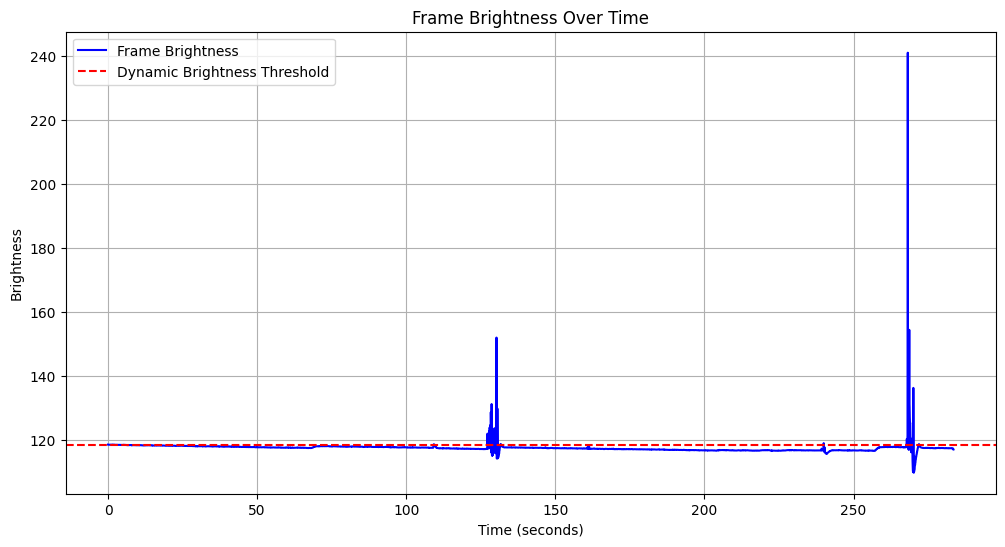

Processing videos: 100%|██████████| 1/1 [01:02<00:00, 62.05s/it]


All clips have been merged into: ./clips/20241012\merged\final_clips.mp4


In [5]:
folder_path = r'C:\Users\user\Pictures\photos\test'
detector = LightningDetector()
detector.process_videos(folder_path)

All combined videos have been merged into: ./final_combined_video.mp4
